## Physics-informed sampling scheme for efficient well placement optimization
<b>MS Thesis </b>
<b>Seoul National University </b>
<b>Department of Energy Systems Engineering </b>
<b>Jongwook Kim </b>
<b>2024.08</b>

### Description
This code will help for efficient well placement optimization using CNN-based proxy by improving an initial sampling.
For more details, you can find a journal paper, <b><i>Physics-informed sampling scheme for efficient well placement optimization</i></b> (JERT).

## 0. Initialization

#### Load modules

In [26]:
import gc
import os.path
import numpy as np
import pandas as pd
import warnings
%load_ext autoreload
%autoreload 2
from packages.sampler import *
from packages.optimization import GlobalOpt
from packages.utils import *
from parsing import args
from packages.Bayes_opt import *
warnings.filterwarnings(action='ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Set parameters

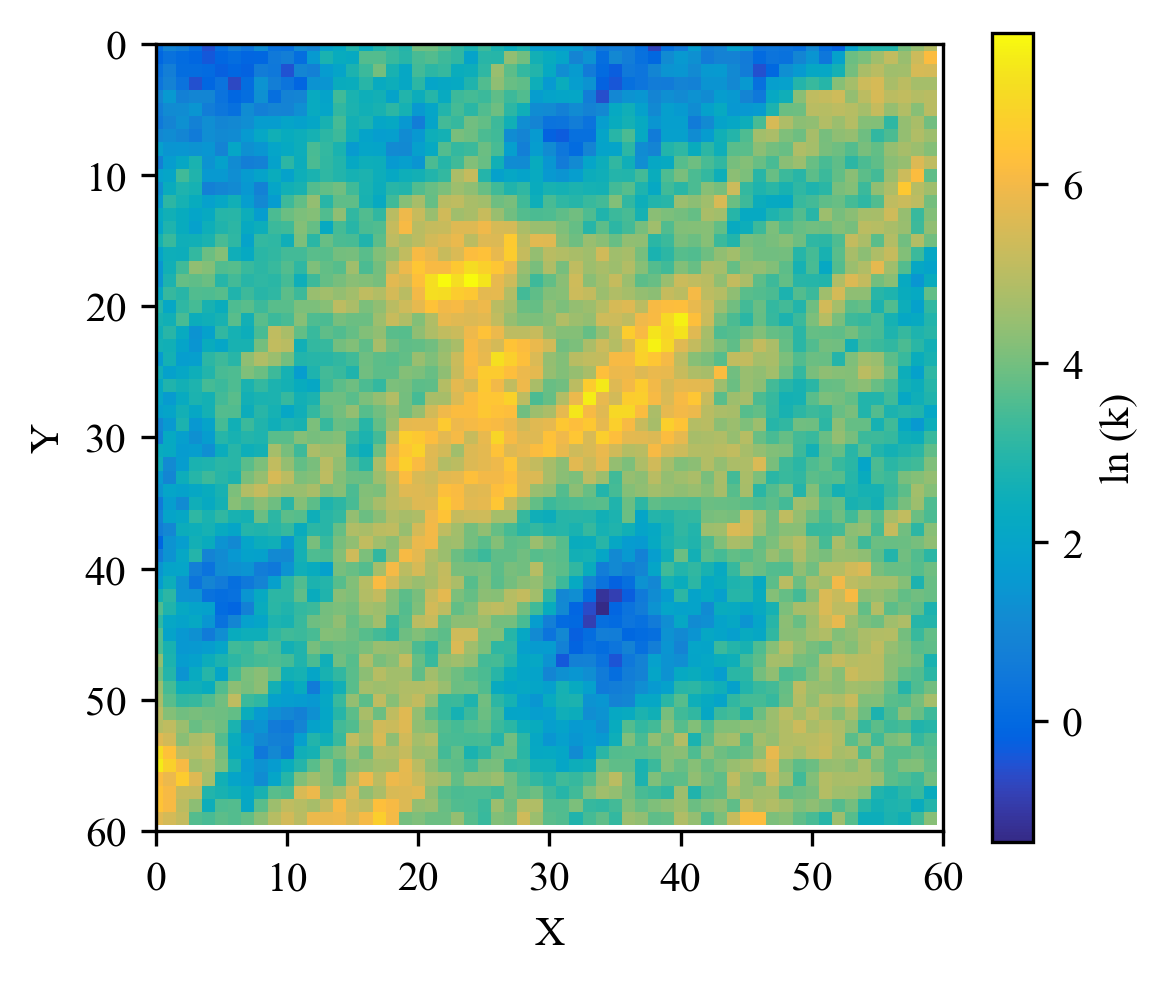

In [27]:
# set permeability
perm = load_matfile(args.perm_mat, 'original')
perm_idx = load_matfile(args.perm_mat, 'selected')
id  = perm_idx[0][0] - 1
# id는 0 ~ 99의 범위를 가짐
# id =
args.permeability = np.array(perm[id])
draw_perm(args.permeability,fname='logperm')
# Setting
tensorboard_setting = {'Use': False,
                            'Filename': f'ECL/Run1',
                            'Tagname': f'Fitness(NPV)'
                            }
sampling_setting = {'Method': args.sampling_method, # Type of Sampling methods {'random', 'uniform', '2stage', 'physics'}
                     'Default radius': True,
                     'Use Quality': False,
                     'Infeasible ratio': args.ratio_of_infeasible,
                     'Number of Samples': args.num_of_train_sample,  # 2000
                     'Number of max wells': args.array_of_wells[-1], # 14
                     'Well array': args.array_of_wells,              # range(5, 15)
                     'Sample array': [int(args.num_of_train_sample/ len(args.array_of_wells)) for _ in args.array_of_wells], # 유정 개수마다 200개
                     'Permeability': args.permeability,
                     'Quality': make_quality(args.permeability),
                     'Parallel': args.parallel,
                     'Process': 8,
                     'Save': f"wo_{args.num_of_train_sample}_{args.sampling_method}_{id}.pkl"
                     }
optimization_setting = {'Algorithm': 'PSO',
                     'Number of particles': args.num_of_particles,
                     'Number of generations': args.num_of_generations,
                     'Proxy': None,
                     'Fine Tune': False,
                     'Use retrain': False,
                     'Span of retrain': 4,
                     'Parallel': args.parallel,
                     'Process': 8,
                     'Save':'PSOResult.pkl',
                     'Tensorboard':tensorboard_setting
                         }
Bayesian_opt_setting = {'Batch_size': (8,256),
                        'Epoch': (50,80),
                        'Lr': (1e-4, 5e-3),
                        'Gamma': (0.005, 0.01)}

proxy_setting = {'Model': args.proxy_name,
                 'Input': args.proxy_input,
                 'Batch_size': args.batch_size, #128
                 'Epoch': args.num_of_epochs, #60
                 'Lr': args.lr,# 3e-3
                 'Line search': args.Line_search,
                 'Valid_pick': args.valid_pick,
                 'Scheduler': args.scheduler,
                 'Gamma': args.gamma,
                 'Silent': False,
                 'Device':args.device,
                 'Save': 'saved_model',
                 'Tensorboard':tensorboard_setting,
                 'Bayesian Optimization': Bayesian_opt_setting
                  }
sampling_setting['Sample array'] = setter(sampling_setting)

## 1. Sampling


#### make samples to train a proxy model

In [3]:
# Random Sampling
sampling_setting['Method'] = 'random'
sampling_setting['Save'] = f"wo_{sampling_setting['Number of Samples']}_{args.sampling_method}_{id}.pkl"
sampling_setting['Sample array'] = setter(sampling_setting)
samples_random = Packer_new(sampling_setting, args=args, permeability=args.permeability, load=False, train_data=True)

Random Sampling...:   0%|          | 0/16 [00:00<?, ?it/s]

now simulate:   0%|          | 0/16 [00:00<?, ?it/s]

In [0]:
# Uniform Sampling
sampling_setting['Method'] = 'uniform'
sampling_setting['Save'] = namer(sampling_setting, id, sampling_setting['Number of Samples'])
sampling_setting['Sample array'] = setter(sampling_setting)
samples_uniform = Packer_new(sampling_setting, args=args, permeability=args.permeability, load=False, train_data=True)

In [3]:
# 2-stage Sampling
sampling_setting['Method'] = '2stage'
sampling_setting['Save'] = namer(sampling_setting, id, sampling_setting['Number of Samples'])
sampling_setting['Sample array'] = setter(sampling_setting)
samples_2stage = Packer_new(sampling_setting, args=args, permeability=args.permeability, load=False, train_data=True, duplicate=samples_uniform, save=False)

In [139]:
# physics Sampling
sampling_setting['Method'] = 'physics'
sampling_setting['Save'] = namer(sampling_setting, id, sampling_setting['Number of Samples'])
sampling_setting['Sample array'] = setter(sampling_setting)
samples_physics = Packer_new(sampling_setting, args=args, permeability=args.permeability, load=False, train_data=True, duplicate=samples_uniform)

#### Visualization of Quality maps and sampling results

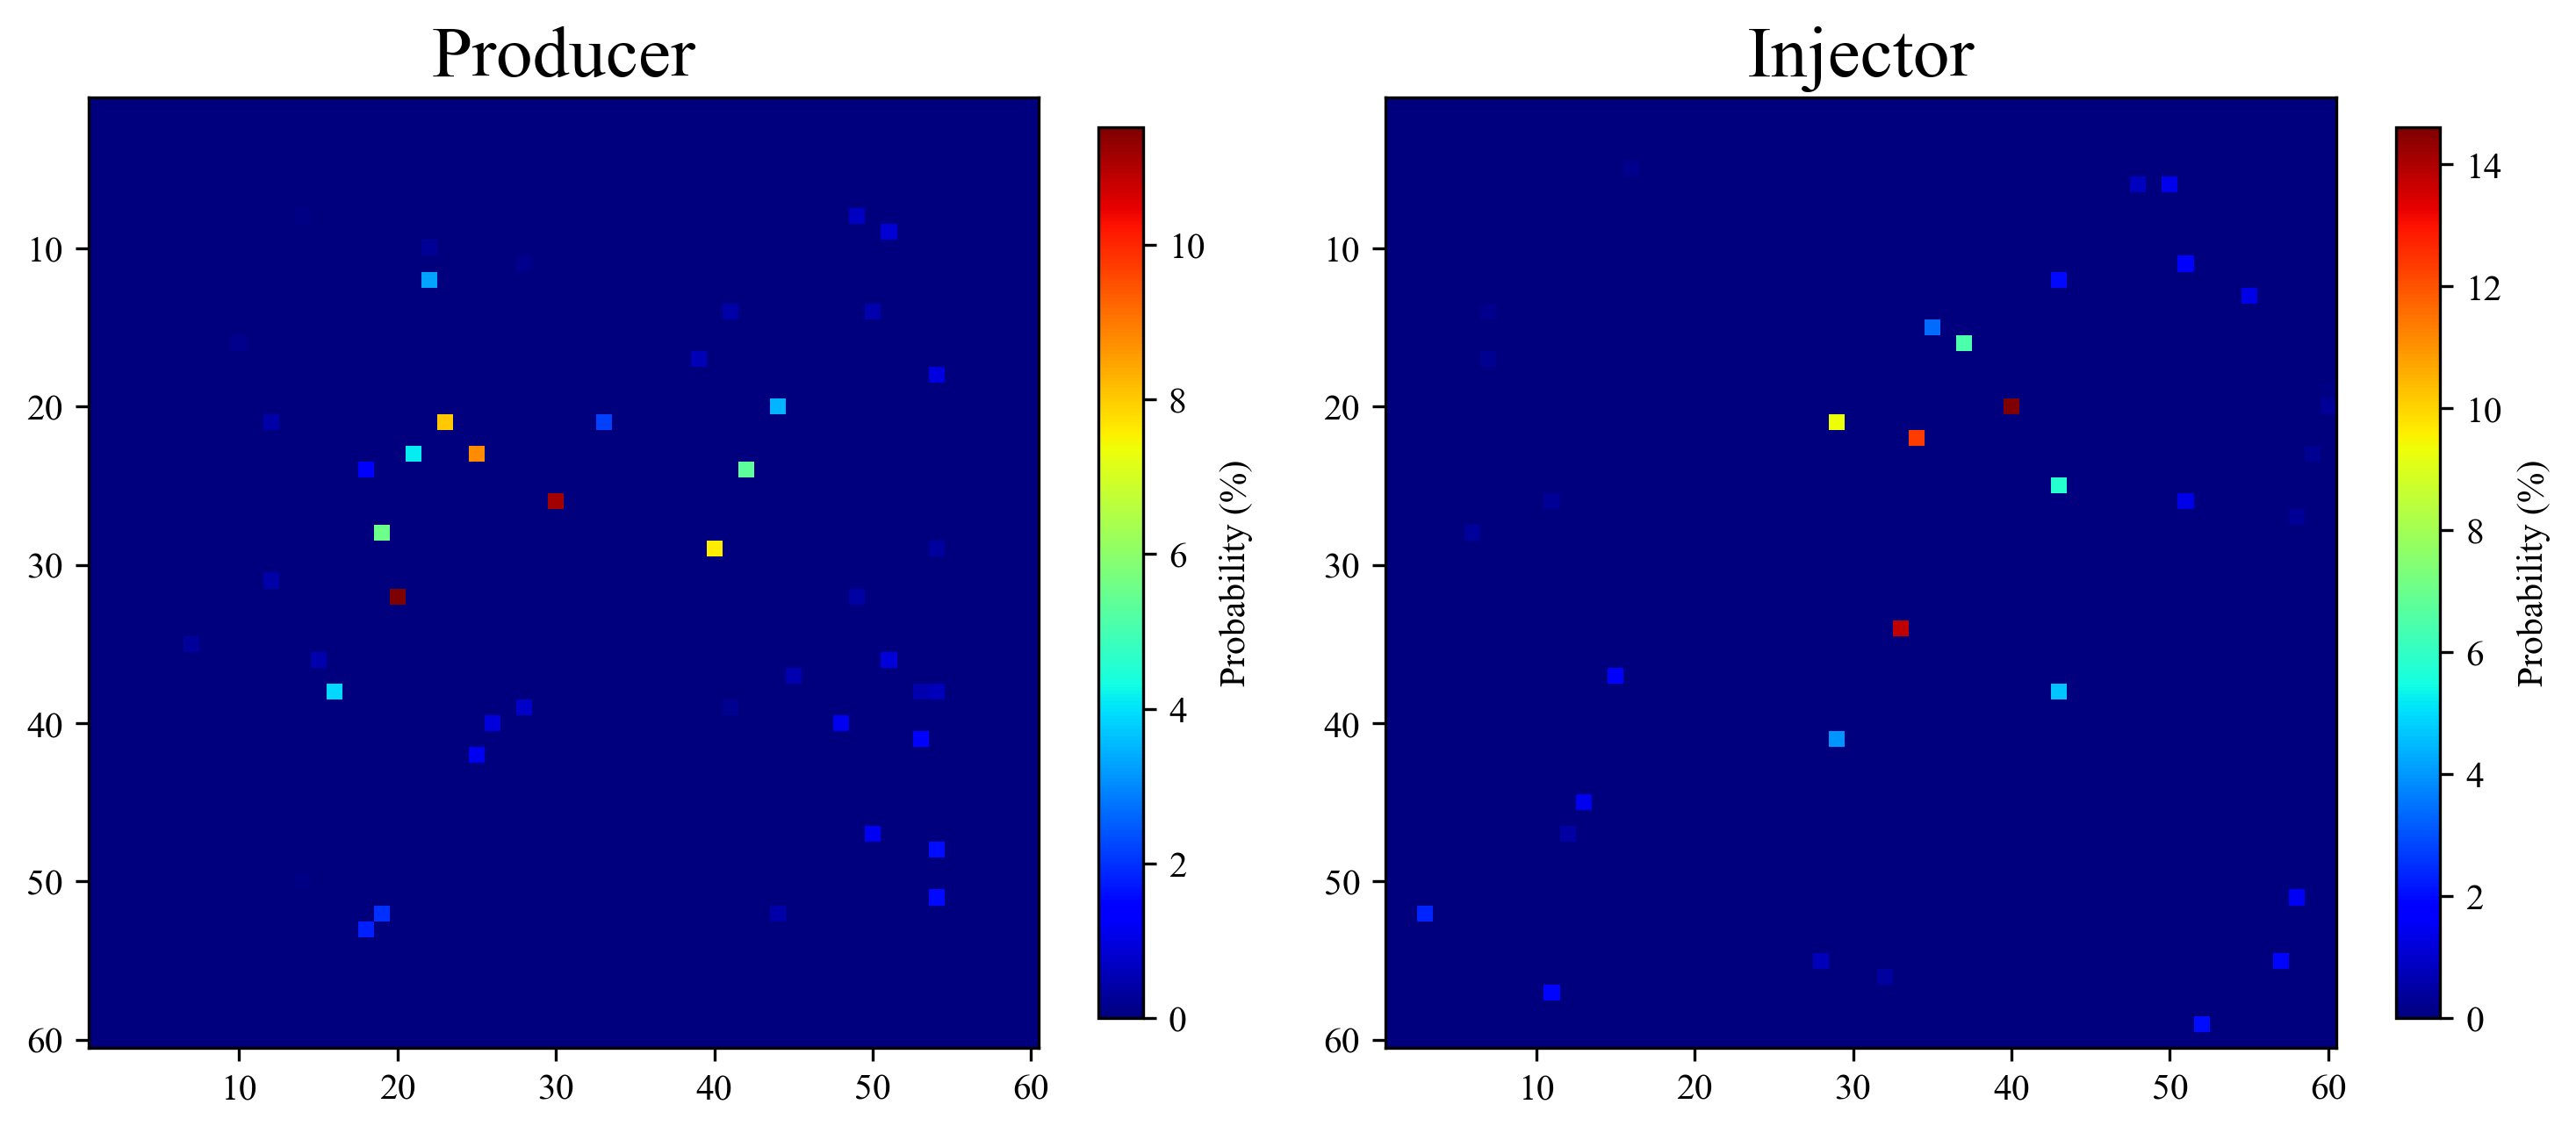

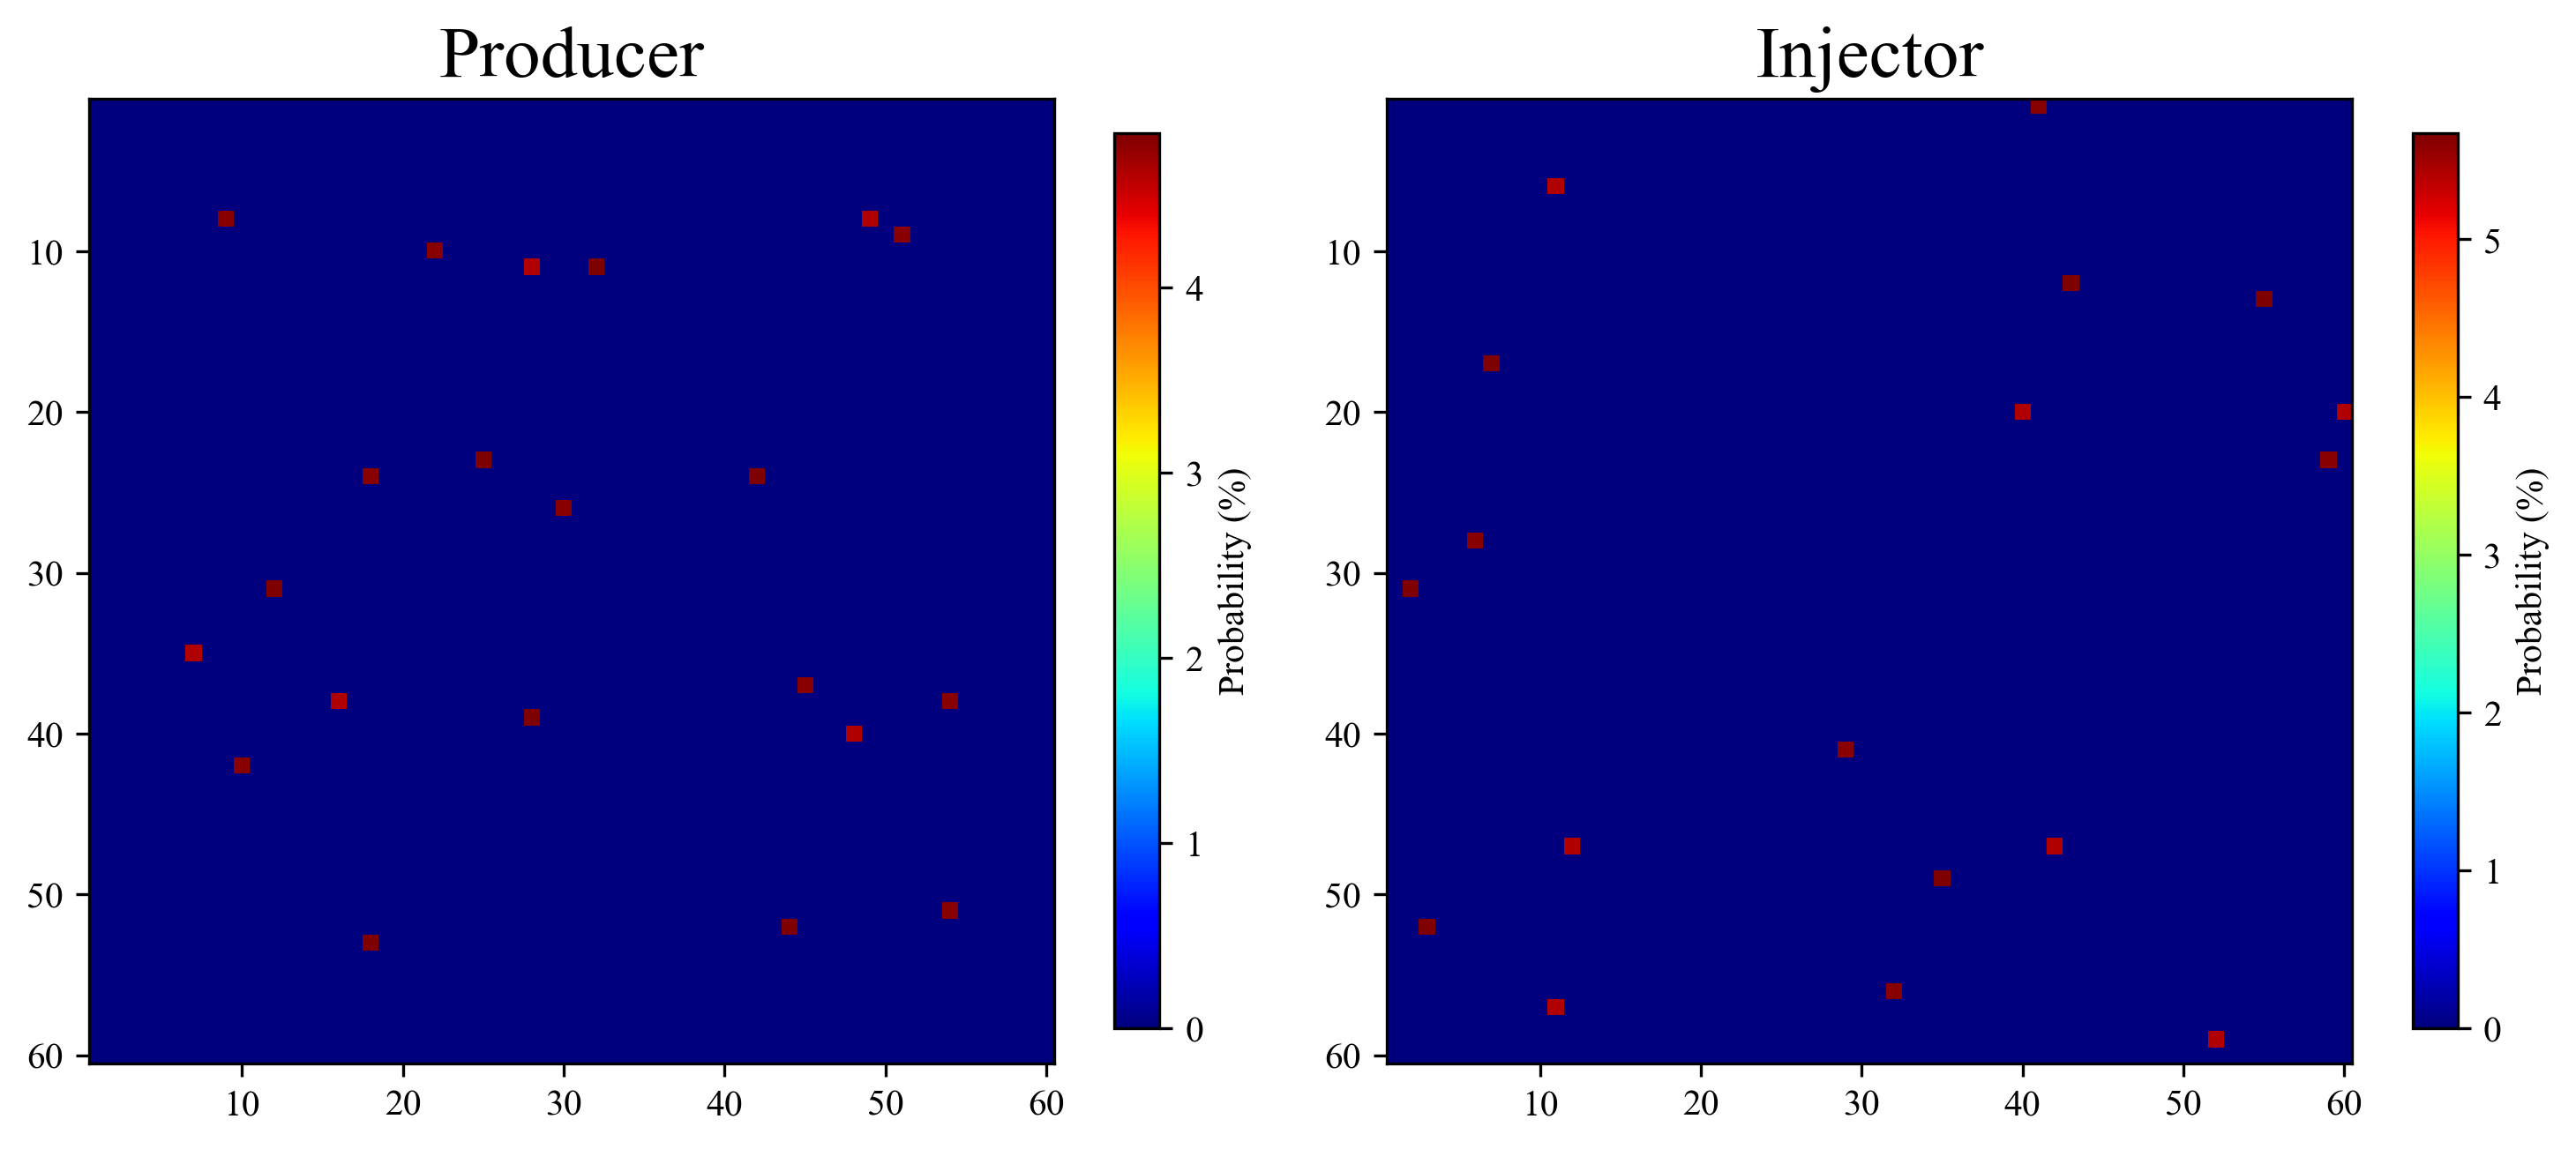

In [4]:
split = int(len(samples_physics)/2)
_, q_npv, _ = get_CDF(samples_2stage[:split], 0.75, view=False, fname=None)
q_sl, _,_ = SLquality(args.permeability, samples_physics[:split], sampling_setting)

# NPV-based quality maps
draw_qualitymap(q_npv, fname='NPV_quality')
# Physics-informed quality maps
draw_qualitymap(q_sl, fname='Physics_quality')

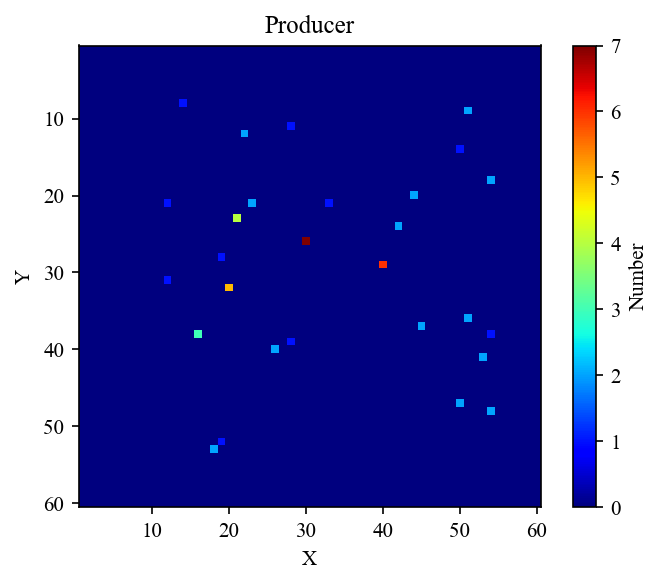

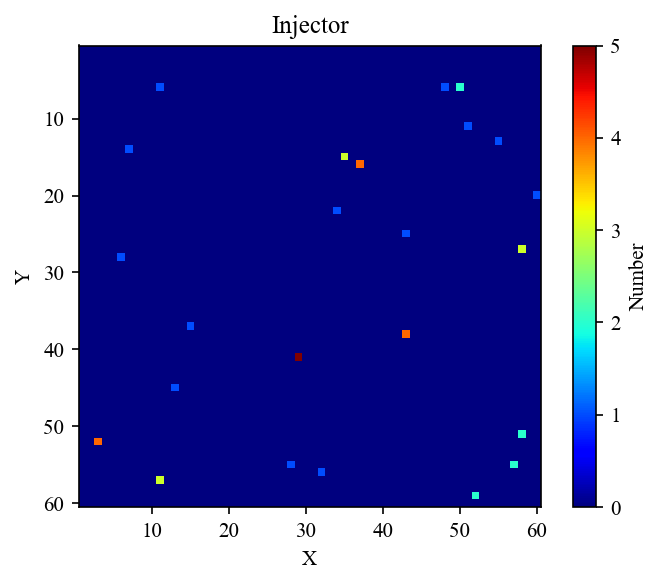

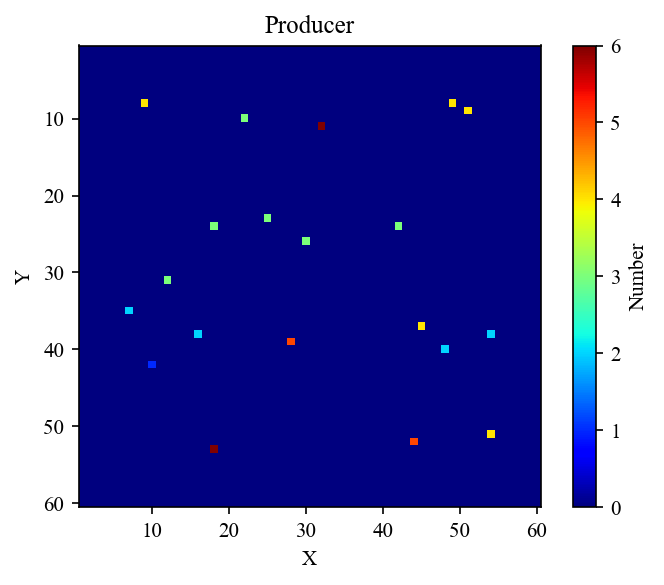

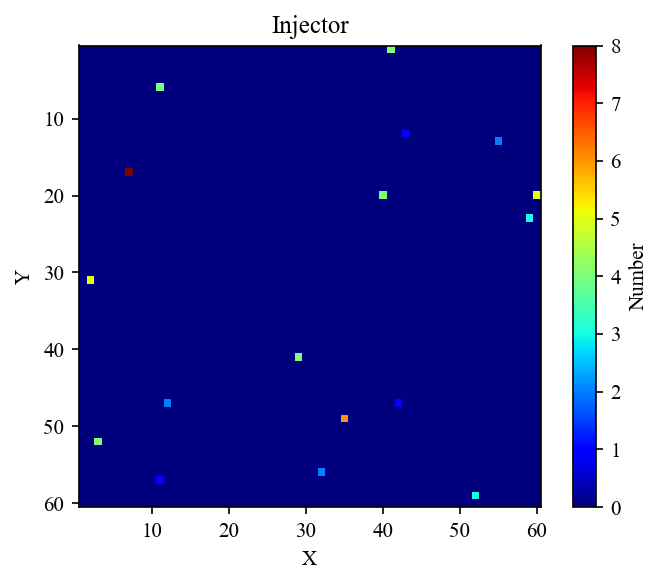

In [5]:
draw_samples(samples_physics[split:], what=1, fname='quality_samples')
draw_samples(samples_physics[split:], what=-1, fname='quality_samples')
draw_samples(samples_2stage[split:], what=1, fname='npv_samples')
draw_samples(samples_2stage[split:], what=-1, fname='npv_samples')

#### NPV histogram of each sampling scheme

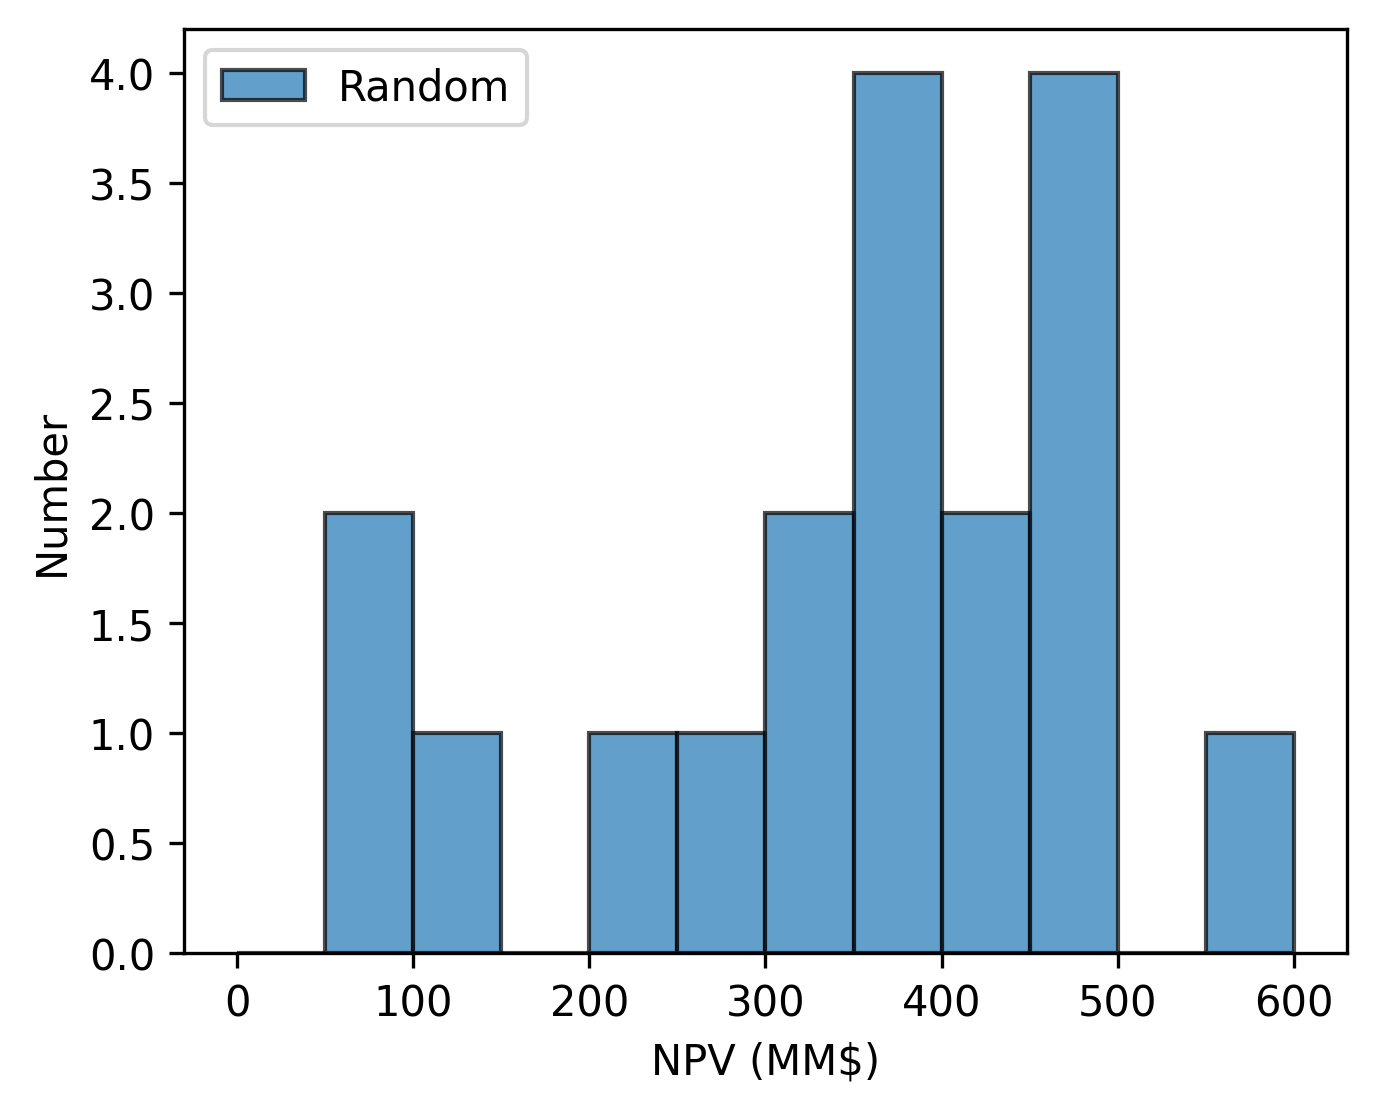

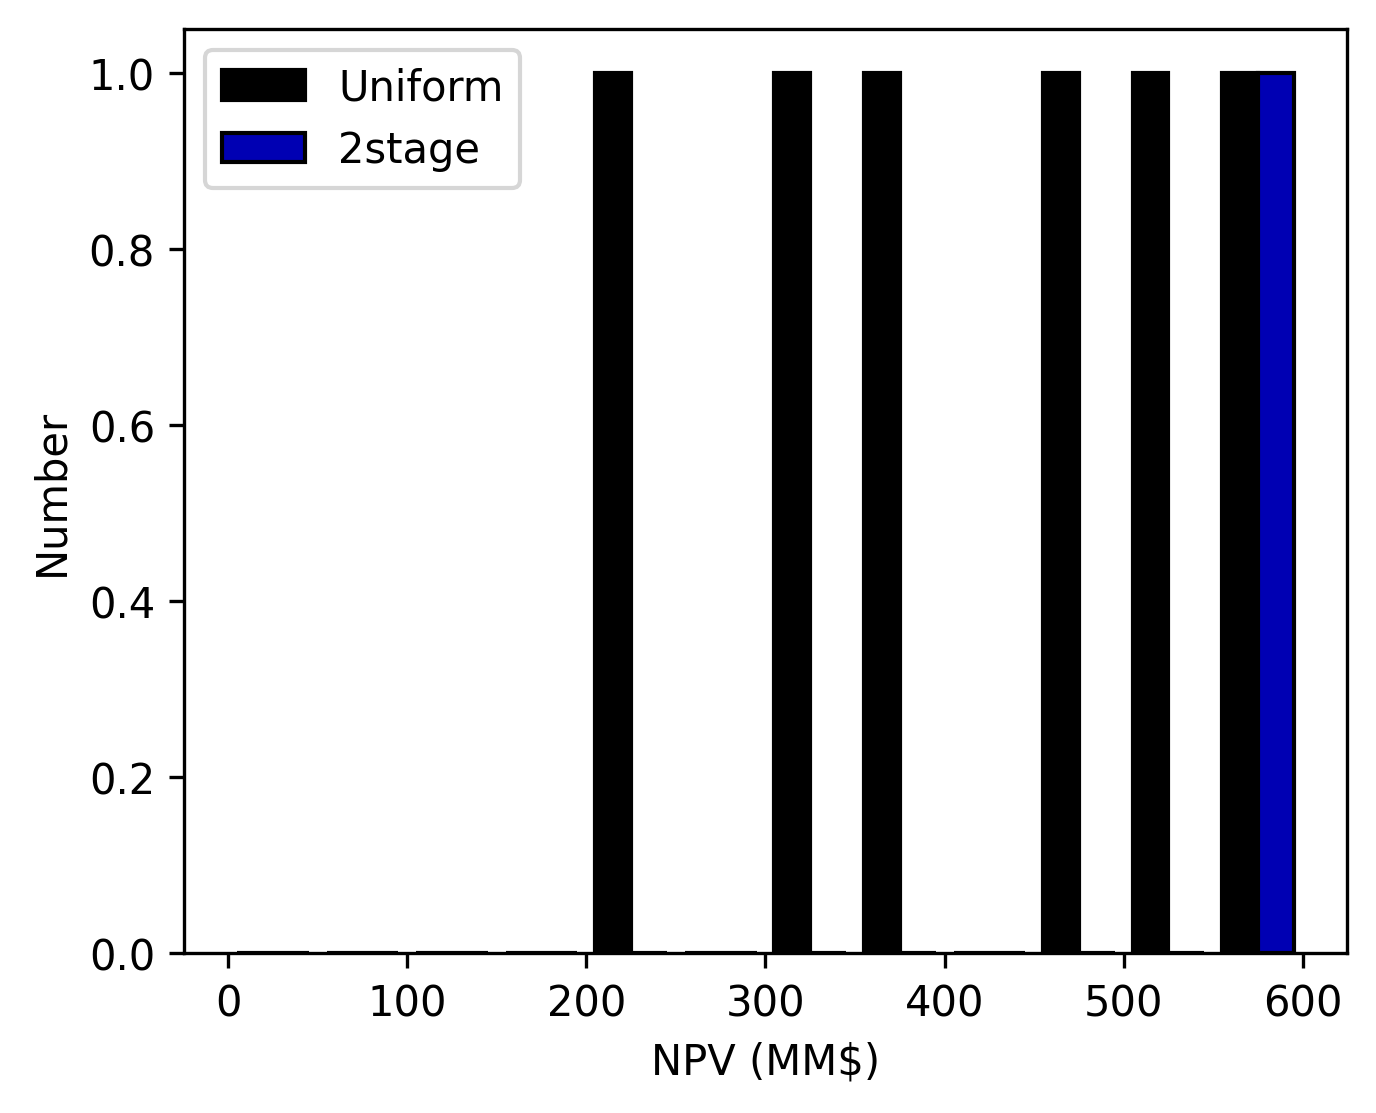

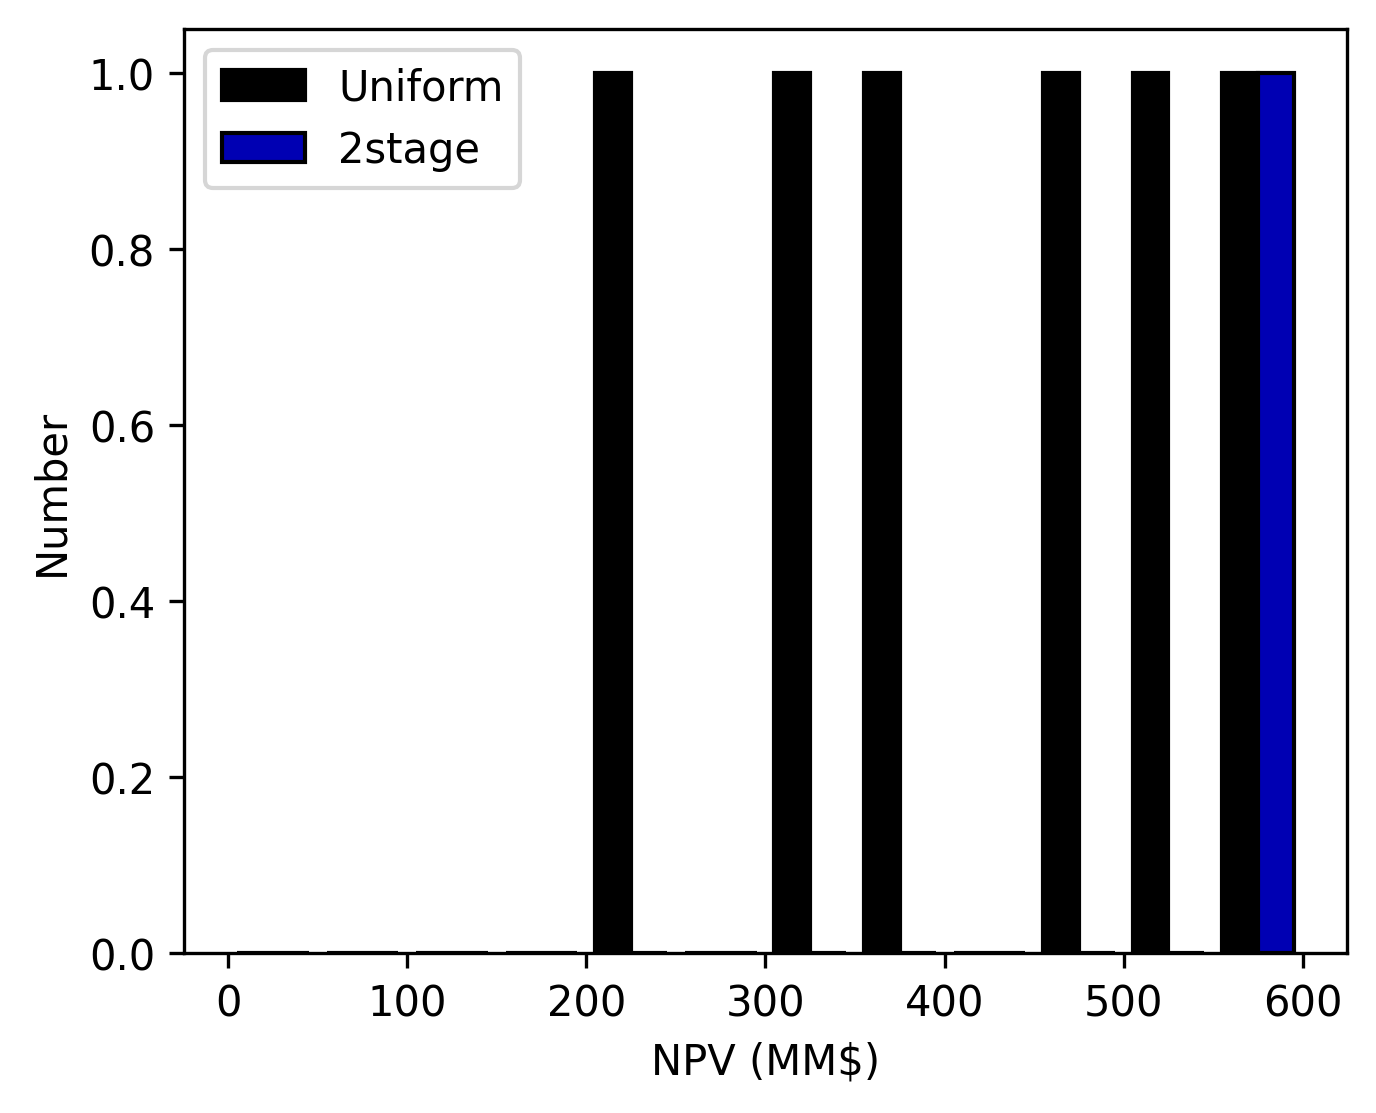

In [4]:
rand = [p.fit/1e6 for p in samples_random]
st = [p.fit/1e6 for p in samples_2stage]
proposed = [p.fit/1e6 for p in samples_physics]

NPV_histogram(rand, bins=np.arange(0, 6.5e2, 0.5e2), is_2stage=False, fname='Random_hist')
NPV_histogram(st, seperated=split,bins=np.arange(0, 6.5e2, 0.5e2), is_2stage=True, fname='NPV_hist')
NPV_histogram(proposed, seperated=split,bins=np.arange(0, 6.5e2, 0.5e2), is_2stage=True, fname='Proposed_hist')

### TOF map preprocessing
tofi라고 이름지어졌지만, tofp에 노이즈가 발생하여 tofp를 전처리하는 것임.

In [5]:
preprocess_tof(samples_random)
preprocess_tof(samples_2stage)
preprocess_tof(samples_mine)

## 2. Proxy modeling
<b>Tensorboard를 이용하여 수행 중인 결과를 실시간으로 확인하는 방법</b>
1. CMD에서 tensorboard --logdir ./logs --port 9999를 입력하고, 할당한 주소에서 확인
2. Jupyter notebook에서 %tensorboard --logdir ./logs --port 9999를 입력하여 IDE에서 바로 확인

<b><i> Bayesian Optimization </i></b>
GP(Gausssian Process) 기반의 최적화 기법으로, GP는 1D Kriging이라고 생각하면 됨.
- Variogram을 통한 Covariance => Exponential integral Kernel
    <b>how?</b> Covariance도 어떻게 보면 상대적인 비유사성을 표현하는 단위이므로!
- 애초에 fitness를 포함한 variables의 관계를 multivariate gaussian distribution으로 가정.

초기의 initial points를 랜덤하게 샘플링(prior sampling)하고, 이를 바탕으로 prosterior probability(정확히 말하면 GP가 예측하는 평균 및 분산)를 얻어 prosterior sampling이 가능함.
Bayesian optimization에서는 posterior sampling은 하지 않지만, acquisition function을 통하여 평균과 분산을 이용하여 불확실성이 큰 지역(Exploration)과 기대값이 높은 지역(Exploitation)을 탐색하여 최적해를 찾는다.

<u>acquisition function</u>
GP가 fitness에 대하여 실제 데이터를 기반으로 다음 번 조사할 parameter value를 확률적으로 계산하여 추천하는 함수.
1. <b>EI(Expected improvement)</b>: exploration과 exploitation이 적절히 수행되도록 고안된 함수. <i>가장 일반적</i>
2. <b>POI(Probability of improvement)</b>: 현재까지 조사된 점들의 함숫값 중 최대 함숫값보다 더 큰 함숫값을 도출할 확률으로 탐색하는 함수.
3. <b>ES(Entropy Search)</b>: 엔트로피가 낮아지도록, 즉, 불확실성이 큰 구간을 탐색하여 불확실성을 낮추도록 하는 함수.
4. <b>UCB(Upper confidence bound)</b>: 평균에 표준편차와 hyperparameter인 kappa를 곱해준 값을 더해주어, 가장 높은 지점을 탐색하는 함수.

In [6]:
seed = 0
fix_seed(seed)
if args.use_bayesopt:
    opt = BayesOpt(args, setting=proxy_setting, samples=samples_random, seed=seed)
    rst = opt.perform_BayesOpt(init_points=5, n_iter=20)
    opt.return_Param(rst.max, proxy_setting)
    with open(f'./cached/Proxy_best_Bayesopt.pkl', 'rb') as f:
        Model_random = pickle.load(f)
else:
    Model_random = ProxyModel(args, samples_random, setting=proxy_setting)
    Model_random.model = Model_random.train_model(samples_random, train_ratio=args.train_ratio,
                                                  validate_ratio=args.validate_ratio,
                                                  saved_dir=Model_random.saved_dir,
                                                  saved_model='saved_model')

with open(f'./cached/Proxy_random_{id}.pkl', 'wb') as f:
    pickle.dump(Model_random, f)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1 		 Training Loss: 1.0229 		 Validation Loss: 1.0138
Validation Loss Decreased(inf--->1.0138) 	 Saving The Model
Epoch 2 		 Training Loss: 1.7069 		 Validation Loss: 0.9722
Validation Loss Decreased(1.0138--->0.9722) 	 Saving The Model
Epoch 3 		 Training Loss: 0.8818 		 Validation Loss: 0.9181
Validation Loss Decreased(0.9722--->0.9181) 	 Saving The Model
Epoch 4 		 Training Loss: 0.5253 		 Validation Loss: 0.9195
Epoch 5 		 Training Loss: 0.4377 		 Validation Loss: 1.0040
Epoch 6 		 Training Loss: 0.3732 		 Validation Loss: 1.0528
Epoch 7 		 Training Loss: 0.2710 		 Validation Loss: 1.1125
Epoch 8 		 Training Loss: 0.3178 		 Validation Loss: 1.2299
Epoch 9 		 Training Loss: 0.2416 		 Validation Loss: 1.3465
Epoch 10 		 Training Loss: 0.2093 		 Validation Loss: 1.5202
Epoch 11 		 Training Loss: 0.2130 		 Validation Loss: 1.7666
Epoch 12 		 Training Loss: 0.1826 		 Validation Loss: 1.9369
Epoch 13 		 Training Loss: 0.2931 		 Validation Loss: 1.9768
Epoch 14 		 Training Loss: 0.3

In [13]:
seed = 0
fix_seed(seed)
if args.use_bayesopt:
    opt = BayesOpt(args, setting=proxy_setting, samples=samples_random, seed=seed)
    rst = opt.perform_BayesOpt(init_points=5, n_iter=20)
    opt.return_Param(rst.max, proxy_setting)
    with open(f'./cached/Proxy_best_Bayesopt.pkl', 'rb') as f:
        Model_2stage = pickle.load(f)
else:
    Model_2stage = ProxyModel(args, samples_2stage, setting=proxy_setting)
    Model_2stage.model = Model_2stage.train_model(samples_2stage, train_ratio=args.train_ratio,
                                validate_ratio=args.validate_ratio,
                                saved_dir=Model_2stage.saved_dir,
                                saved_model='saved_model_2stage')

with open(f'./cached/Proxy_2stage_{id}.pkl', 'wb') as f:
    pickle.dump(Model_2stage, f)

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch 1 		 Training Loss: 1.1539 		 Validation Loss: 0.9904
Validation Loss Decreased(inf--->0.9904) 	 Saving The Model
Epoch 2 		 Training Loss: 1.9297 		 Validation Loss: 1.0437
Epoch 3 		 Training Loss: 2.3280 		 Validation Loss: 1.0592
Epoch 4 		 Training Loss: 0.8807 		 Validation Loss: 1.0855
Epoch 5 		 Training Loss: 0.5953 		 Validation Loss: 1.1468
Epoch 6 		 Training Loss: 0.4975 		 Validation Loss: 1.2671
Epoch 7 		 Training Loss: 0.3912 		 Validation Loss: 1.3954
Epoch 8 		 Training Loss: 0.3442 		 Validation Loss: 1.4781
Epoch 9 		 Training Loss: 0.4634 		 Validation Loss: 1.5118
Epoch 10 		 Training Loss: 0.3121 		 Validation Loss: 1.5051
Epoch 11 		 Training Loss: 0.3363 		 Validation Loss: 1.4696
Epoch 12 		 Training Loss: 0.3379 		 Validation Loss: 1.4393
Epoch 13 		 Training Loss: 0.3459 		 Validation Loss: 1.4299
Epoch 14 		 Training Loss: 0.2991 		 Validation Loss: 1.4583
Epoch 15 		 Training Loss: 0.2673 		 Validation Loss: 1.5316
Epoch 16 		 Training Loss: 0.2510 

In [8]:
fix_seed(seed)
if args.use_bayesopt:
    opt = BayesOpt(args, setting=proxy_setting, samples=samples_physics, seed=seed)
    rst = opt.perform_BayesOpt(init_points=5, n_iter=20)
    opt.return_Param(rst.max, proxy_setting)
    with open(f'./cached/Proxy_best_Bayesopt.pkl', 'rb') as f:
        Model_2stage = pickle.load(f)
else:
    Model_quality = ProxyModel(args, samples_physics, setting=proxy_setting)
    Model_quality.model = Model_quality.train_model(samples_physics, train_ratio=args.train_ratio,
                                                    validate_ratio=args.validate_ratio,
                                                    saved_dir=Model_quality.saved_dir,
                                                    saved_model='saved_model_slquality')

with open(f'./cached/Proxy_quality_{id}.pkl', 'wb') as f:
    pickle.dump(Model_quality, f)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1 		 Training Loss: 1.0517 		 Validation Loss: 0.7591
Validation Loss Decreased(inf--->0.7591) 	 Saving The Model
Epoch 2 		 Training Loss: 2.3918 		 Validation Loss: 1.0146
Epoch 3 		 Training Loss: 1.2885 		 Validation Loss: 1.2507
Epoch 4 		 Training Loss: 0.9857 		 Validation Loss: 1.4090
Epoch 5 		 Training Loss: 0.6028 		 Validation Loss: 1.6058
Epoch 6 		 Training Loss: 0.3379 		 Validation Loss: 1.9255
Epoch 7 		 Training Loss: 0.3868 		 Validation Loss: 2.0989
Epoch 8 		 Training Loss: 0.3533 		 Validation Loss: 2.3542
Epoch 9 		 Training Loss: 0.2221 		 Validation Loss: 2.6550
Epoch 10 		 Training Loss: 0.2570 		 Validation Loss: 2.7476
Epoch 11 		 Training Loss: 0.1970 		 Validation Loss: 2.7191
Epoch 12 		 Training Loss: 0.2290 		 Validation Loss: 2.6322
Epoch 13 		 Training Loss: 0.2289 		 Validation Loss: 2.6034
Epoch 14 		 Training Loss: 0.2716 		 Validation Loss: 2.5403
Epoch 15 		 Training Loss: 0.1725 		 Validation Loss: 2.5325
Epoch 16 		 Training Loss: 0.2049 

In [9]:
pred = [p[0]/1e6 for p in Model_random.predictions]
true = [p[0]/1e6 for p in Model_random.reals]
get_regression(true, pred,min_=0,max_=550,fname='./fig/Random_proxy')

pred = [p[0]/1e6 for p in Model_2stage.predictions]
true = [p[0]/1e6 for p in Model_2stage.reals]
get_regression(true, pred,min_=0,max_=550,fname='./fig/2stage_proxy')

pred = [p[0]/1e6 for p in Model_quality.predictions]
true = [p[0]/1e6 for p in Model_quality.reals]
get_regression(true, pred,min_=0,max_=550,fname='./fig/Quality_proxy')

### Well placement optimization using CNN-based Proxy

Random Sampling...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Evaluate gbest...


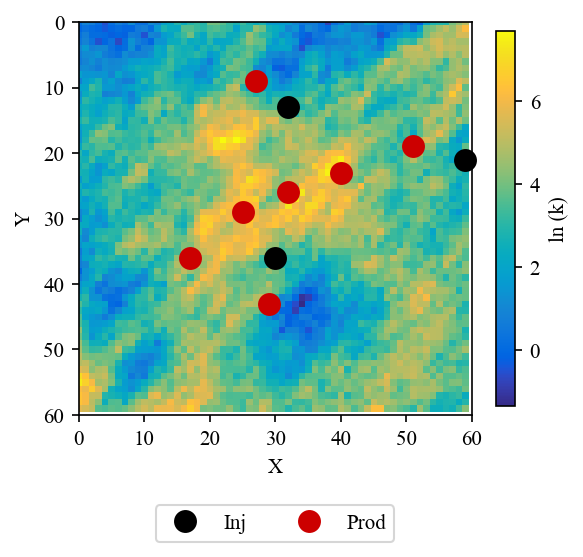

Random Sampling...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Evaluate gbest...


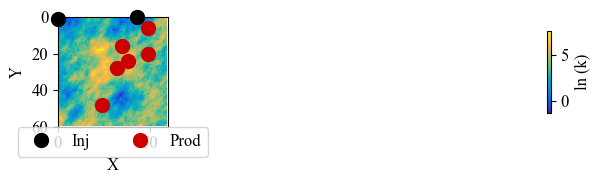

Random Sampling...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Evaluate gbest...


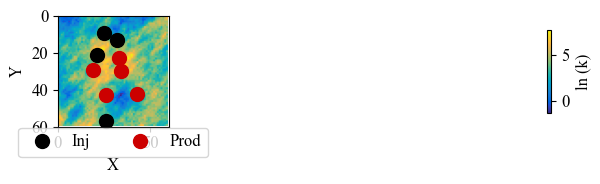

Random Sampling...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Evaluate gbest...


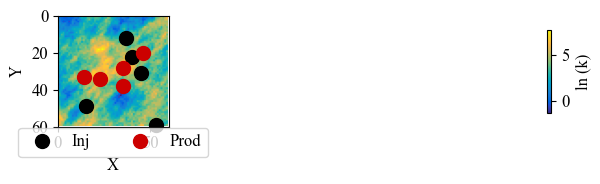

Random Sampling...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Evaluate gbest...


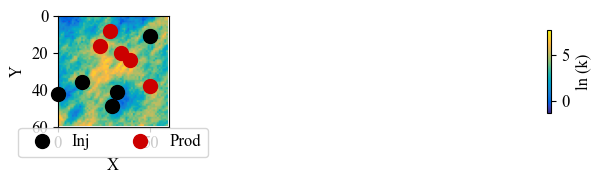

Random Sampling...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Evaluate gbest...


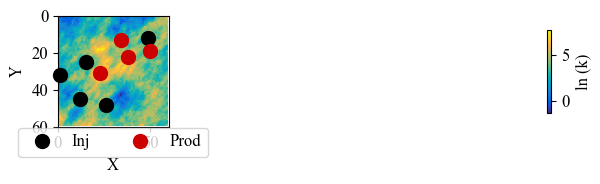

Random Sampling...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
sampling_setting = opt_sampling_setter(sampling_setting, optimization_setting)
sampling_setting['Infeasible ratio'] = 0
optimization_setting['Tensorboard']['Use'] = False
optimization_setting['Tensorboard']['Tagname'] = f'Fitness(NPV)'
args.parallel = False
optimization_setting['Parallel'] = False

for seed in range(args.number_of_optimization):
    # ECL Run
    # fix_seed(seed)
    # tensorboard_setting['Filename'] = f'ECL/ECL_{seed}_{id}'
    # optimization_setting['Proxy'] = None
    # placement_positions = Packer(sampling_setting, args=args, permeability=args.permeability, load=False,save=False, train_data=False)
    # WPO_ecl = GlobalOpt(args, placement_positions, args.permeability, setting=optimization_setting, sample=samples_random)
    # WPO_ecl.iterate(optimization_setting['Number of generations'])
    # wellplacement(WPO_ecl.algorithm.gbest[-1],filename=f'ECL_{seed}_{id}')
    # with open(os.path.join(args.cached_dir, f'./WPO_ecl_{seed}_{id}.pkl'), 'wb') as f:
    #    pickle.dump(WPO_random,f)
    # del WPO_ecl
    # gc.collect()

    # Random
    #fix_seed(seed)
    optimization_setting['Tensorboard']['Filename'] = f'CNN/Random_{seed}_{id}'
    optimization_setting['Proxy'] = Model_random
    placement_positions = Packer_new(sampling_setting, args=args, permeability=args.permeability, load=False, save=False, train_data=False)
    WPO_random = GlobalOpt(args, placement_positions, args.permeability, setting=optimization_setting, sample=samples_random)
    WPO_random.iterate(optimization_setting['Number of generations'])
    wellplacement(WPO_random.algorithm.gbest[-1],filename=f'Random_{seed}_{id}')
    error_random = draw_relative_error(WPO_random,f'random_{seed}')
    # draw_graph2(WPO_ecl, WPO_random, f'Graph_Random_{j}_{id}')
    with open(os.path.join(args.cached_dir, f'./WPO_random_{seed}_{id}.pkl'), 'wb') as f:
       pickle.dump(WPO_random,f)
    del WPO_random
    gc.collect()
    # 2stage
    fix_seed(seed)
    optimization_setting['Tensorboard']['Filename'] = f'CNN/2stage_{seed}_{id}'
    optimization_setting['Proxy'] = Model_2stage
    placement_positions = Packer_new(sampling_setting, args=args, permeability=args.permeability, load=False, save=False, train_data=False)
    WPO_2stage = GlobalOpt(args, placement_positions, args.permeability, setting=optimization_setting, sample=samples_2stage)
    WPO_2stage.iterate(optimization_setting['Number of generations'])
    wellplacement(WPO_2stage.algorithm.gbest[-1],filename=f'2stage_{seed}_{id}')
    error_2stage = draw_relative_error(WPO_2stage,f'2stage_{seed}')
    # draw_graph2(WPO_ecl, WPO_2stage, f'Graph_2stage_{j}_{id}')
    with open(os.path.join(args.cached_dir, f'./WPO_2stage_{seed}_{id}.pkl'), 'wb') as f:
        pickle.dump(WPO_2stage, f)
    del WPO_2stage
    gc.collect()

    # Quality
    fix_seed(seed)
    optimization_setting['Tensorboard']['Filename'] = f'CNN/quality_{seed}_{id}'
    optimization_setting['Proxy'] = Model_quality
    placement_positions = Packer_new(sampling_setting, args=args, permeability=args.permeability, load=False, save=False, train_data=False)
    WPO_quality = GlobalOpt(args, placement_positions, args.permeability, setting=optimization_setting, sample=samples_physics)
    WPO_quality.iterate(optimization_setting['Number of generations'])
    wellplacement(WPO_quality.algorithm.gbest[-1],filename=f'quality_{seed}_{id}')
    error_quality = draw_relative_error(WPO_quality,f'quality_{seed}')
    #draw_graph2(WPO_ecl, WPO_quality, f'Graph_quality_{j}_{id}')

    with open(os.path.join(args.cached_dir, f'./WPO_quality_{seed}_{id}.pkl'), 'wb') as f:
        pickle.dump(WPO_quality,f)
    del WPO_quality
    gc.collect()
    seed += 1